https://realpython.com/k-means-clustering-python/

In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## WYNIK BADANIA

Etykiety to ciągi znaków zawierające skróty typów nowotworów:

 - BRCA: Rak inwazyjny piersi
 - COAD: Gruczolakorak okrężnicy
 - KIRC: Rak jasnokomórkowy nerki
 - LUAD: Gruczolakorak płuc
 - PRAD: Gruczolakorak prostaty

In [2]:
df2 = pd.read_csv('/home/wmoszczy/Cluster_analysis/dane/labels.csv')
true_label_names = df2.Class.to_list()
#true_label_names
print(df2.Class.value_counts())
df2.head(3)

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD


#### KODOWANIE WYNIKU aby go użyć...

In [3]:
df2['ClassK'] = pd.Categorical(df2.Class).codes
df2[['Class','ClassK']].head(8)

,Class,ClassK
0,PRAD,4
1,LUAD,3
2,PRAD,4
3,PRAD,4
4,BRCA,0
5,PRAD,4
6,KIRC,2
7,PRAD,4


#### SŁOWNIK

In [4]:
df2[['Class','ClassK']].value_counts()

Class  ClassK
BRCA   0         300
KIRC   2         146
LUAD   3         141
PRAD   4         136
COAD   1          78
dtype: int64

In [5]:
true_label_names[:5]

['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA']

###  KODOWANIE 

In [6]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

## ANALIZA GENOWA

In [7]:
df = pd.read_csv('/home/wmoszczy/Cluster_analysis/dane/data.csv')
df.head(4)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0


In [8]:
df3 = df
del df3['Unnamed: 0']

In [9]:
data = np.array(df3)  
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

## REDUKCJA WYMIAROWOŚCI
Przebadano tutaj ponad 20 tys genów, pacjentów jest 800 osób - każdy gen to wymiar, więc trzeba zredukować ilość genów (przekleństwo wymiarowości) 


In [10]:
df.shape

(801, 20531)

## Analiza składowych głównych (PCA) 
jest jedną z wielu technik redukcji wymiarowości. PCA przekształca dane wejściowe, rzutując je na mniejszą liczbę wymiarów zwanych komponentami . Komponenty wychwytują zmienność danych wejściowych poprzez liniową kombinację cech danych wejściowych.

In [11]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),   # standaryzacja Mini-max
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

Teraz, po zbudowaniu potoku do przetwarzania danych, utworzysz oddzielny potok do wykonywania klastrów k -średnich. Zastąpisz następujące domyślne argumenty klasy KMeans:

### init: Użyjesz "k-means++"zamiast , "random"
aby upewnić się, że centroidy są inicjowane z pewną odległością między nimi. W większości przypadków będzie to poprawa w stosunku do "random".

### n_init: 
Zwiększysz liczbę inicjalizacji, aby znaleźć stabilne rozwiązanie.

### max_iter: 
Zwiększysz liczbę iteracji na inicjalizację, aby zapewnić zbieżność k -means.

Zbuduj potok grupowania k -means z argumentami zdefiniowanymi przez użytkownika w KMeanskonstruktorze:



#### Liczba klastrów

In [12]:
n_clusters = 4

In [13]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [14]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

Wywołanie .fit()z dataargumentem as wykonuje wszystkie kroki potoku na data:

In [15]:
pipe.fit(df)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=4, n_init=50,
                                         random_state=42))]))])

### OCENA

In [16]:
preprocessed_data = pipe["preprocessor"].transform(data)

/home/wmoszczy/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [17]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [18]:
silhouette_score(preprocessed_data, predicted_labels)

0.4905418337333298

In [19]:
adjusted_rand_score(true_labels, predicted_labels)

0.565124821743308

/home/wmoszczy/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wmoszczy/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


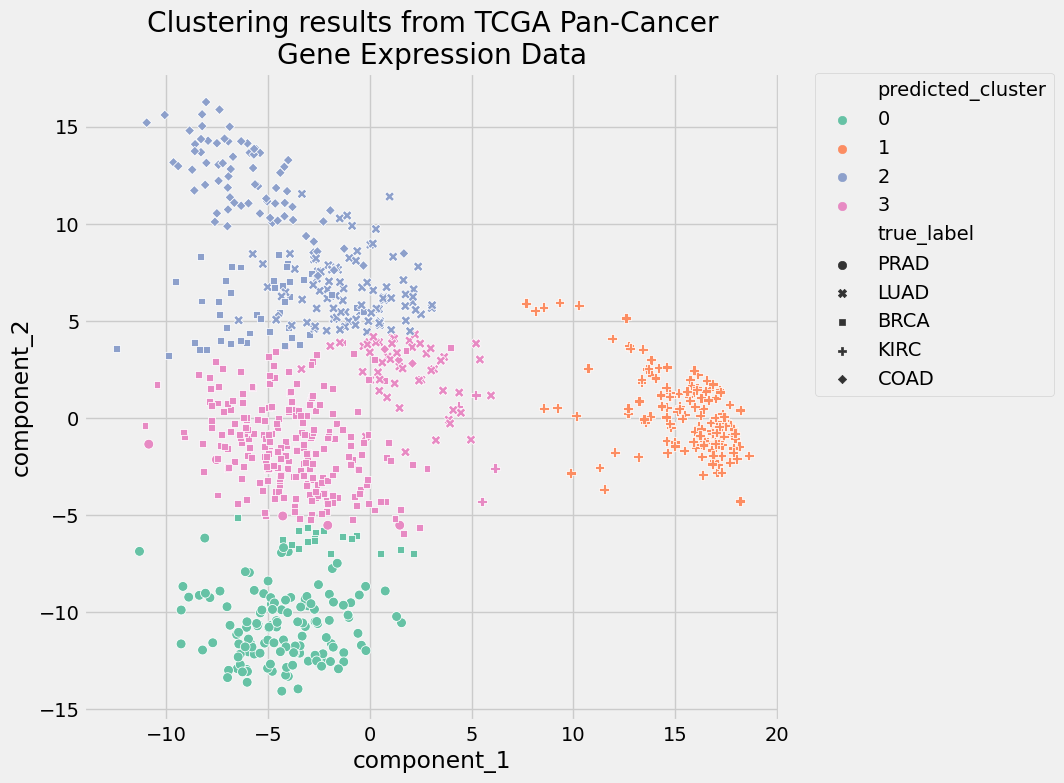

In [20]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

Wizualna reprezentacja klastrów potwierdza wyniki dwóch metryk oceny klastrów. Wydajność twojego potoku była całkiem dobra. Klastry tylko nieznacznie zachodziły na siebie, a przypisania klastrów były znacznie lepsze niż losowe.